In [1]:
# This code is for comparing the difference between AI generated paths, human navigated paths, and the actual shortest path

import pandas as pd
import networkx as nx
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from src.data.paths_loader import *
from src.utils.evaluation_utils import *
from src.utils.plot_utils import *
import plotly.io as pio

# load the links file
df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])

# Create a directed graph
G = nx.from_pandas_edgelist(df, source='origin', target='destination', create_using=nx.DiGraph())

# load the origin and destination pairs, in the first column
ori_dest = pd.read_csv('data/ori_dest.csv').iloc[:, 0].tolist()
ori_dest = [eval(pair) for pair in ori_dest]

In [2]:
# for each pair, load the AI generated path and the human navigated path
AI_paths = load_ai_paths('data/paths', ori_dest)
improved_ai_paths = load_ai_paths('data/paths_improved_prompt', ori_dest)
human_paths = load_human_paths(ori_dest)
shortest_paths = get_shortest_path(G, ori_dest)

In [3]:
# print the average path length for each pair
for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    shortest_path = shortest_paths[pair]
    # calculat the mean path length
    ai_path_len = sum([len(path) for path in ai_path]) / len(ai_path) if ai_path else 0
    improved_ai_path_len = sum([len(path) for path in improved_ai_paths[pair]]) / len(improved_ai_paths[pair]) if improved_ai_paths[pair] else 0
    human_path_len = sum([len(path) for path in human_path]) / len(human_path) if human_path else 0
    shortest_path_len = len(shortest_path[0]) if shortest_path else 0
    print(f"Start: {start_article}, Target: {target_article}")
    print(f"AI path length: {ai_path_len}, improved AI path length: {improved_ai_path_len}, Human path length: {human_path_len}, Shortest path length: {shortest_path_len}")


Start: Brain, Target: Telephone
AI path length: 5.6, improved AI path length: 5.0, Human path length: 7.1, Shortest path length: 4
Start: Theatre, Target: Zebra
AI path length: 8.6, improved AI path length: 10.75, Human path length: 7.83646408839779, Shortest path length: 4
Start: Pyramid, Target: Bean
AI path length: 5.6, improved AI path length: 5.0, Human path length: 8.246105919003115, Shortest path length: 4
Start: Batman, Target: Wood
AI path length: 7.5, improved AI path length: 5.8, Human path length: 7.263513513513513, Shortest path length: 4
Start: Bird, Target: Great_white_shark
AI path length: 9.6, improved AI path length: 10.0, Human path length: 5.695652173913044, Shortest path length: 4
Start: Batman, Target: The_Holocaust
AI path length: 5.4, improved AI path length: 6.0, Human path length: 5.420168067226891, Shortest path length: 4
Start: Bird, Target: Adolf_Hitler
AI path length: 5.0, improved AI path length: 4.0, Human path length: 5.401869158878505, Shortest path le

d:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


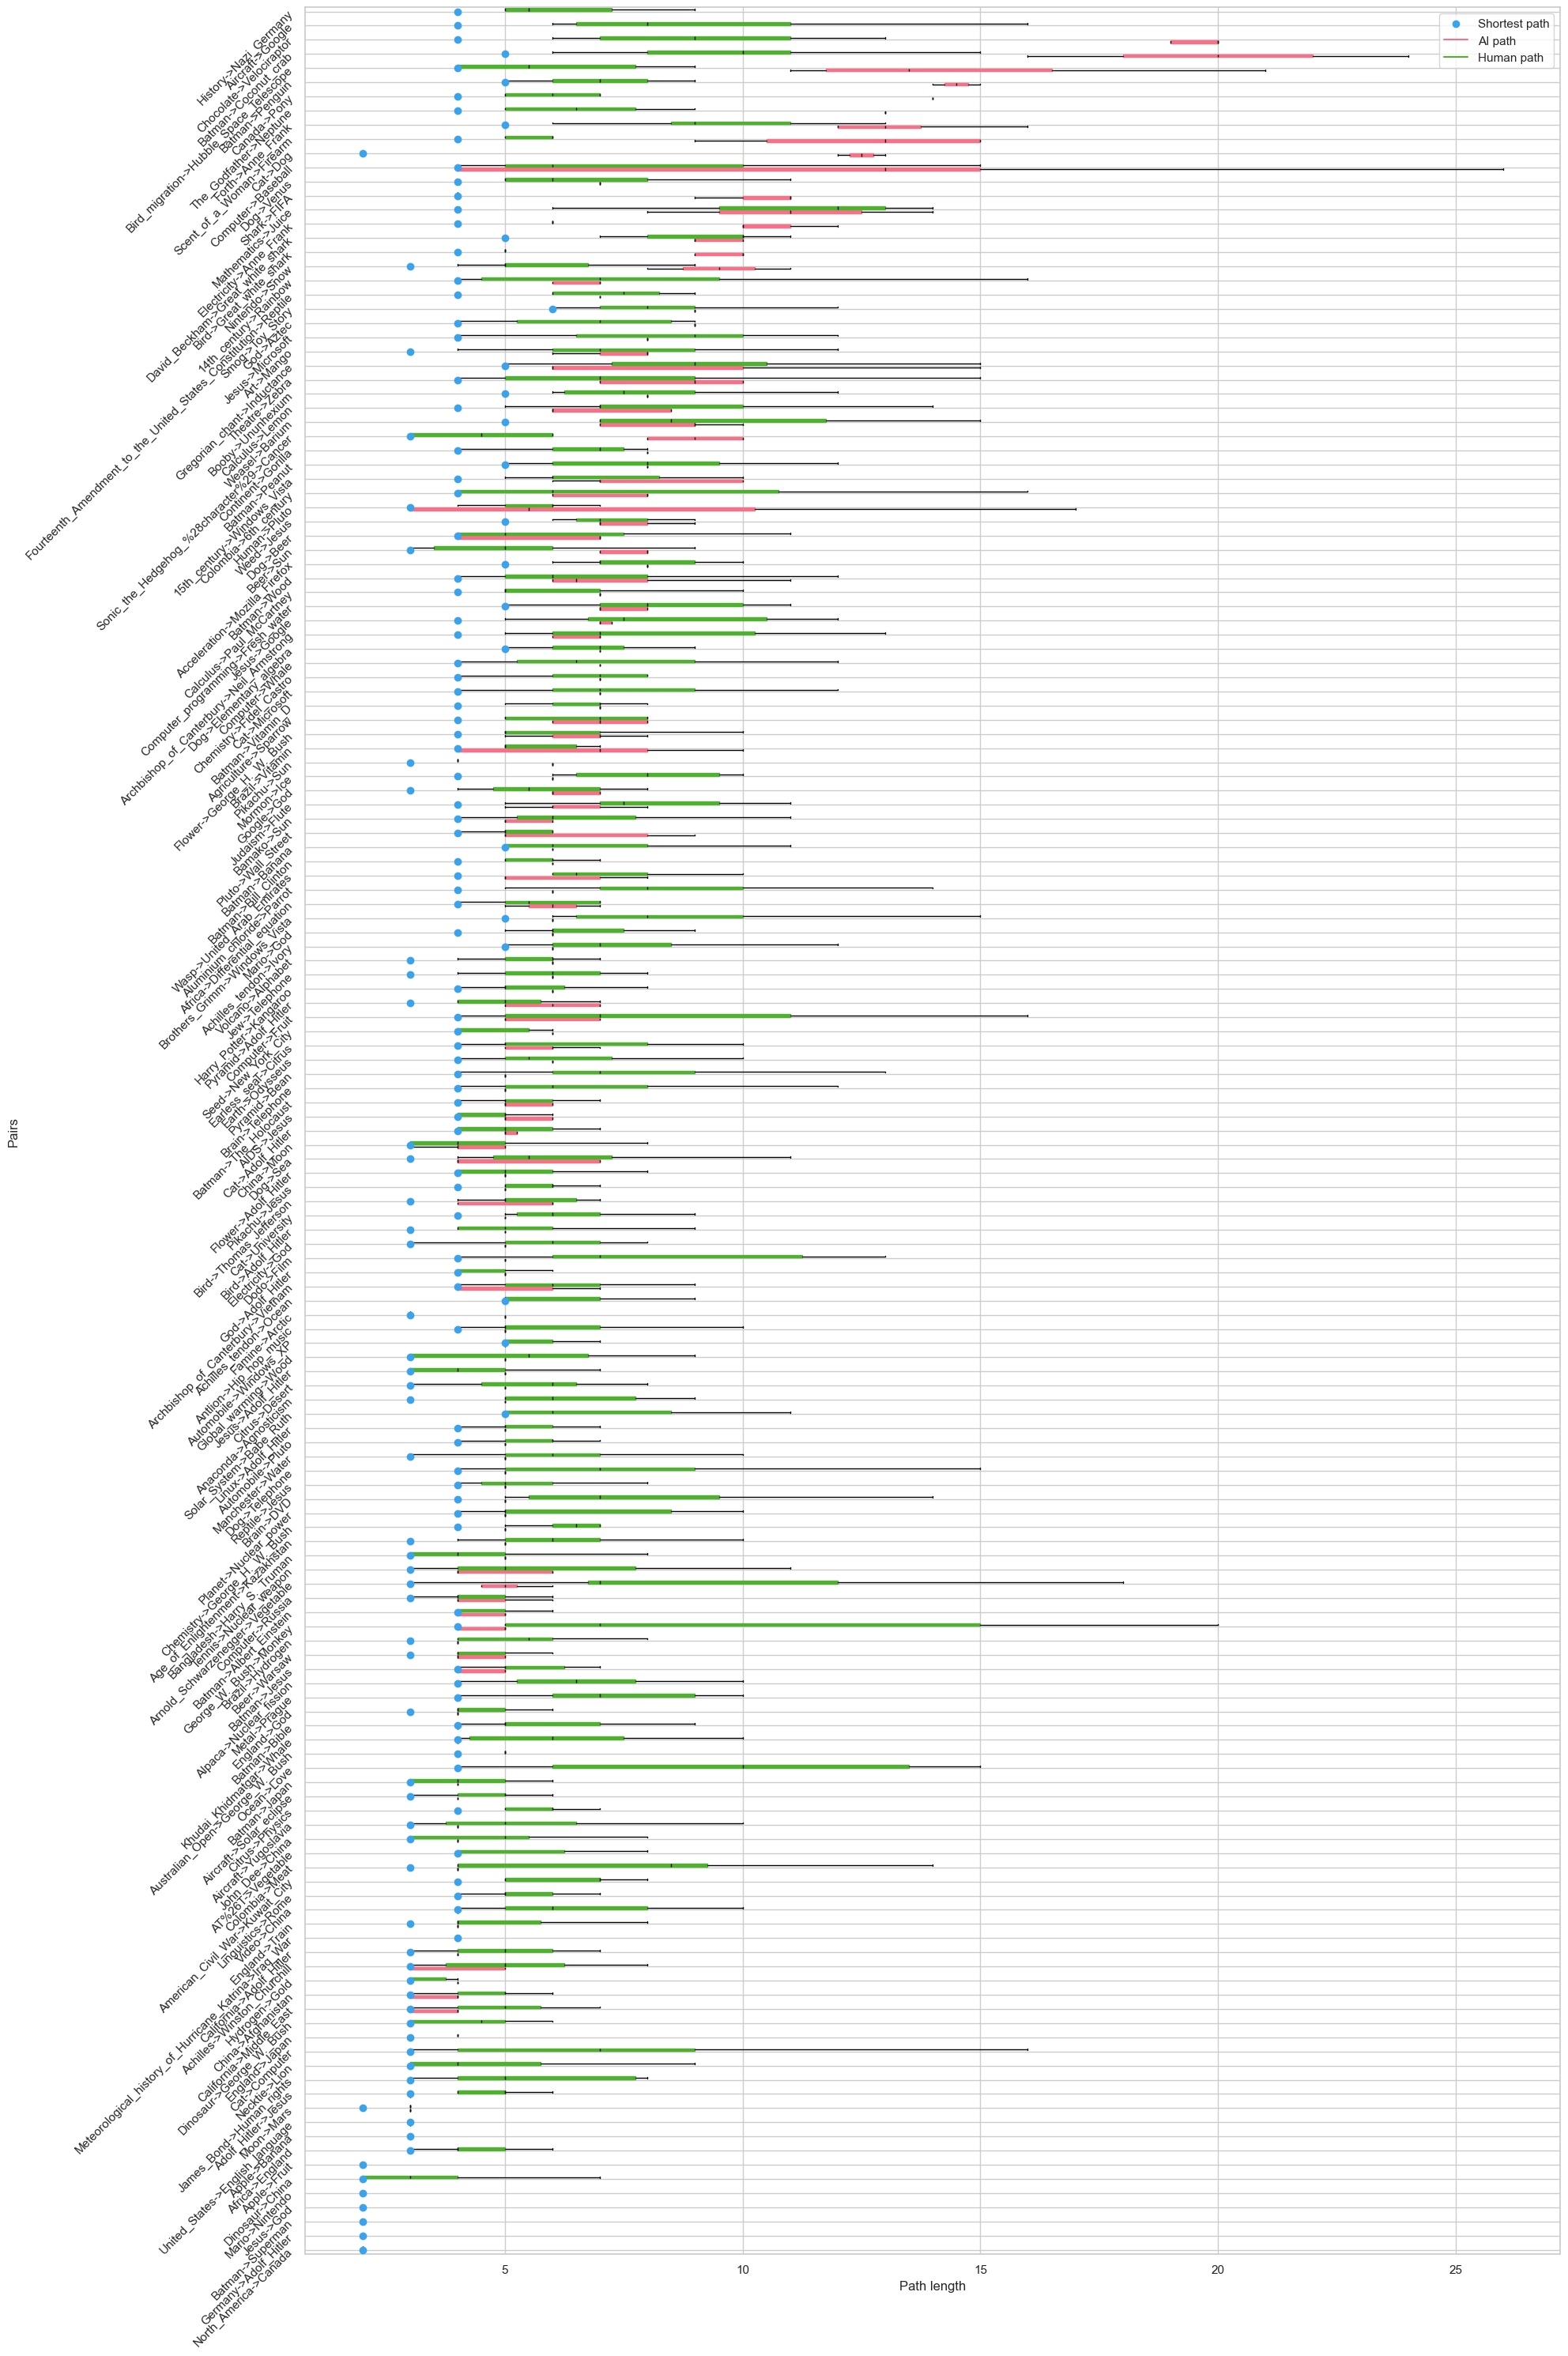

In [4]:
# the x-axis is the path length, the y-axis is the pairs

ai_path_len = [[len(path) for path in AI_paths[pair]] for pair in ori_dest]
improved_ai_paths_len = [[len(path) for path in improved_ai_paths[pair]] for pair in ori_dest]
human_path_len = [[len(path) for path in human_paths[pair]] for pair in ori_dest]
shortest_path_len = [[len(shortest_paths[pair][0])] for pair in ori_dest]

# Calculate mean values of AI path lengths and sort pairs based on these means
mean_ai_path_len = [np.mean(lengths) for lengths in ai_path_len]
sorted_indices = np.argsort(mean_ai_path_len)
sorted_ori_dest = [ori_dest[i] for i in sorted_indices]
sorted_ai_path_len = [ai_path_len[i] for i in sorted_indices]
sorted_improved_ai_path_len = [improved_ai_paths_len[i] for i in sorted_indices]
sorted_human_path_len = [human_path_len[i] for i in sorted_indices]
sorted_shortest_path_len = [shortest_path_len[i] for i in sorted_indices]



# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 3)

# Adjust the figure size to lengthen the graph
plt.figure(figsize=(20, 30))

# Add jitter to the boxplot
def add_jitter(data, jitter_amount=0.1):
    return data + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

jittered_ai_path_len = [add_jitter(lengths) for lengths in sorted_ai_path_len]
# jittered_improved_ai_path_len = [add_jitter(lengths) for lengths in sorted_improved_ai_path_len]
jittered_human_path_len = [add_jitter(lengths) for lengths in sorted_human_path_len]
jittered_shortest_path_len = [add_jitter(lengths) for lengths in sorted_shortest_path_len]

# Plot AI and human paths in the same line for each pair
positions = np.array(range(len(sorted_ori_dest))) * 3.0
plt.boxplot(sorted_ai_path_len, positions=positions - 0.4, sym='', widths=0.6, vert=False, patch_artist=True,
            boxprops=dict(facecolor=palette[0], color=palette[0]),
            medianprops=dict(color='black'))
plt.boxplot(sorted_human_path_len, positions=positions + 0.4, sym='', widths=0.6, vert=False, patch_artist=True,
            boxprops=dict(facecolor=palette[1], color=palette[1]),
            medianprops=dict(color='black'))

# Plot shortest paths
plt.scatter(sorted_shortest_path_len, positions, color=palette[2], label='Shortest path', zorder=3)

# Create dummy plots for the legend
plt.plot([], [], color=palette[0], label='AI path')
plt.plot([], [], color=palette[1], label='Human path')

plt.yticks(positions, [f"{pair[0]}->{pair[1]}" for pair in sorted_ori_dest], rotation=45, ha='right')
plt.xlabel("Path length")
plt.ylabel("Pairs")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import plotly.graph_objects as go
import numpy as np

# Parameters
sample_fraction = 0.15  # Fraction of sublists to select
outlier_threshold = 2  # Factor of the mean to use as the outlier threshold
fixed_height_per_pair = 50  # Fixed height for each pair in pixels
fixed_width = 1400  # Fixed width for the figure
x_jitter_offset = 0.025  # Small horizontal shift to avoid overlapping
seed = 58
np.random.seed(seed)
y_offset = 0.15

# Standard Colors
PRIMARY_BLUE = "#3A55D1"  # AI paths
SOFT_ORANGE = "#F2994A"   # Human paths
LIGHT_GREEN = "#6FCF97"   # Shortest paths
BACKGROUND = "#F0F4FF"    # Plot background
LIGHT_GRAY = "#E0E8F0"    # Grid lines

# Helper function to filter out large values within a sublist
def filter_outliers(data, threshold):
    mean = np.mean(data)
    return [x for x in data if x <= mean * threshold]

# Sample indices first and preserve original order
def sample_indices(data, fraction):
    total = len(data)
    num_samples = max(1, int(total * fraction))
    sampled_indices = sorted(np.random.choice(total, num_samples, replace=False))
    return sampled_indices

# Sample the indices
sampled_indices = sample_indices(sorted_ai_path_len, sample_fraction)

# Filter all paths using the same sampled indices
aligned_ai_path_len = [filter_outliers(sorted_ai_path_len[i], outlier_threshold) for i in sampled_indices]
aligned_human_path_len = [filter_outliers(sorted_human_path_len[i], outlier_threshold) for i in sampled_indices]
aligned_shortest_path_len = [sorted_shortest_path_len[i] for i in sampled_indices]
selected_ori_dest = [sorted_ori_dest[i] for i in sampled_indices]

# Assign y-positions for alignment
y_positions = np.arange(len(sampled_indices))

# Adjust figure height
total_height = fixed_height_per_pair * len(y_positions)

# Create the Plotly figure
fig = go.Figure()

# Add grey reference lines for each pair
for y in y_positions:
    fig.add_shape(
        type="line",
        x0=0, x1=1, y0=y, y1=y,
        xref="paper", yref="y",
        line=dict(color=LIGHT_GRAY, width=1, dash="dot")
    )

# Apply horizontal jitter for AI and Human paths
def jitter(data, offset):
    return [x + offset for x in data]

# Helper function to calculate min and max
def calculate_min_max(data):
    """Return min and max of a list."""
    if not data:  # Handle empty lists
        return None, None
    min_val = min(data)
    max_val = max(data)
    return min_val, max_val

# Standard Colors with Transparency
PRIMARY_BLUE = "rgba(58, 85, 209, 0.7)"  # AI paths - Light Blue with opacity
SOFT_ORANGE = "rgba(242, 153, 74, 0.7)"  # Human paths - Soft Orange with opacity
LIGHT_GREEN = "rgba(111, 207, 151, 0.8)" # Shortest paths - Light Green with slight opacity
BACKGROUND = "#F0F4FF"                   # Plot background
LIGHT_GRAY = "#E0E8F0"                   # Grid lines



# Plot AI paths
for y, lengths in zip(y_positions, aligned_ai_path_len):
    if lengths:
        min_val, max_val = calculate_min_max(lengths)
        median_val = np.median(lengths)  # Calculate median
        if min_val is not None:
            plot_max_val = max_val if max_val > min_val else min_val + 0.1
            fig.add_trace(go.Bar(
                x=[plot_max_val - min_val],
                y=[y + y_offset],
                base=min_val,
                name="AI",
                marker=dict(color=PRIMARY_BLUE),
                orientation='h',
                width=0.35,
                hovertemplate=f"<b>Min:</b> {min_val}<br>"
                              f"<b>Median:</b> {median_val}<br>"
                              f"<b>Max:</b> {max_val}<extra></extra>",
                showlegend=bool(y == 0)
            ))

# Plot Human paths
for y, lengths in zip(y_positions, aligned_human_path_len):
    if lengths:
        min_val, max_val = calculate_min_max(lengths)
        median_val = np.median(lengths)  # Calculate median
        if min_val is not None:
            plot_max_val = max_val if max_val > min_val else min_val + 0.1
            fig.add_trace(go.Bar(
                x=[plot_max_val - min_val],
                y=[y - y_offset],
                base=min_val,
                name="Human",
                marker=dict(color=SOFT_ORANGE),
                orientation='h',
                width=0.35,
                hovertemplate=f"<b>Min:</b> {min_val}<br>"
                              f"<b>Median:</b> {median_val}<br>"
                              f"<b>Max:</b> {max_val}<extra></extra>",
                showlegend=bool(y == 0)
            ))


# Plot Shortest paths
for y, lengths in zip(y_positions, aligned_shortest_path_len):
    if lengths:
        fig.add_trace(go.Scatter(
            x=lengths,
            y=[y] * len(lengths),
            mode='markers',
            name="Shortest",
            marker=dict(color=LIGHT_GREEN, size=10, line=dict(color="white", width=1.5)),
            hovertemplate=f"<b>Shortest Path Length:</b> {lengths[0]}<extra></extra>",
            showlegend=bool(y == 0)
        ))

# Update layout
fig.update_layout(
    title=dict(
        text="Path Length Comparison",
        font=dict(family="Arial, sans-serif", size=24, color="rgba(0, 0, 0, 0.7)")
    ),
    xaxis=dict(
        title="Path Length",
        title_standoff=10,  # Add space between title and axis
        side="top",  # Move the title to the top
        gridcolor=LIGHT_GRAY,
        zerolinecolor=LIGHT_GRAY
    ),
    yaxis=dict(
        tickvals=y_positions,
        ticktext=[f"{pair[0]} → {pair[1]}" for pair in selected_ori_dest],
        tickangle=0,
        tickfont=dict(size=15, family="Arial, sans-serif", color="rgba(0, 0, 0, 0.8)"),
        gridcolor=LIGHT_GRAY
    ),
    plot_bgcolor=BACKGROUND,
    paper_bgcolor="white",
    width=fixed_width,
    height=total_height,
    showlegend=True,
    legend=dict(
        font=dict(color="rgba(0, 0, 0, 0.7)"),
        bgcolor="white",
        bordercolor=LIGHT_GRAY,
        borderwidth=1
    )
)

# Show the plot
fig.show()


d:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# pio.write_html(fig, "path_length_comparison.html", full_html=True)

In [7]:
# Get Sentence embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = {node: model.encode(node.replace('_', ' ')) for node in G.nodes}

d:\Anaconda\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning:

1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)



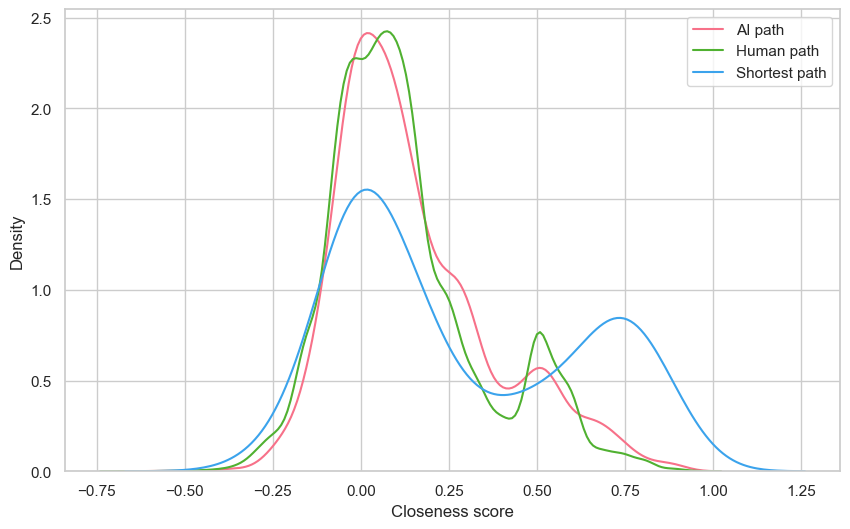

In [8]:
# Calculate closeness scores for AI paths and human paths
ai_closeness_scores = {}
human_closeness_scores = {}
optimal_closeness_scores = {}
ai_target_scores = {}
human_target_scores = {}
optimal_target_scores = {}

for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in ai_path]
    human_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in human_path]
    optimal_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in shortest_paths[pair]]
    ai_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in ai_path]
    human_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in human_path]
    optimal_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in shortest_paths[pair]]


# Plot to show the difference in closeness scores distribution between AI paths and human paths
plt.figure(figsize=(10, 6))
ai_scores = [score for pair in ori_dest for score in ai_closeness_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_closeness_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_closeness_scores[pair]]
ai_scores = [score for sublist in ai_scores for score in sublist]
human_scores = [score for sublist in human_scores for score in sublist]
optimal_scores = [score for sublist in optimal_scores for score in sublist]
sns.kdeplot(ai_scores, label='AI path', color=palette[0])
sns.kdeplot(human_scores, label='Human path', color=palette[1])
sns.kdeplot(optimal_scores, label='Shortest path', color=palette[2])
plt.xlabel("Closeness score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [9]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde

# Function to clean and calculate KDE for smooth curves
def calculate_kde(data, points=100):
    # Clean data: remove NaN and infinite values
    clean_data = np.array(data)
    clean_data = clean_data[~np.isnan(clean_data)]  # Remove NaNs
    clean_data = clean_data[np.isfinite(clean_data)]  # Remove infinities
    
    if len(clean_data) == 0:
        raise ValueError("No valid data points available after cleaning.")
    
    kde = gaussian_kde(clean_data)
    x_range = np.linspace(min(clean_data), max(clean_data), points)
    y_range = kde(x_range)
    return x_range, y_range

# Clean data and calculate KDE
ai_x, ai_y = calculate_kde(ai_scores)
human_x, human_y = calculate_kde(human_scores)
optimal_x, optimal_y = calculate_kde(optimal_scores)

# Create smooth density plots
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ai_x, y=ai_y,
    mode='lines',
    name='AI path',
    line=dict(color=PRIMARY_BLUE, width=3),
    hovertemplate="AI path: %{y:.3f}<extra></extra>"  # Round to 3 decimal places
))

fig.add_trace(go.Scatter(
    x=human_x, y=human_y,
    mode='lines',
    name='Human path',
    line=dict(color=SOFT_ORANGE, width=3),
    hovertemplate="Human path: %{y:.3f}<extra></extra>"  # Round to 3 decimal places
))

fig.add_trace(go.Scatter(
    x=optimal_x, y=optimal_y,
    mode='lines',
    name='Shortest path',
    line=dict(color=LIGHT_GREEN, width=3),
    hovertemplate="Shortest path: %{y:.3f}<extra></extra>"  # Round to 3 decimal places
))

# Update layout for aesthetics and fixed size
fig.update_layout(
    title="Closeness Scores Distribution",
    xaxis_title="Closeness Score",
    yaxis_title="Density",
    plot_bgcolor=BACKGROUND,
    paper_bgcolor=BACKGROUND,
    legend=dict(
        x=0.7, y=0.95,
        bgcolor=BACKGROUND,
        bordercolor=LIGHT_GRAY,
        borderwidth=1
    ),
    font=dict(size=12),
    width=900,   # Fixed width
    height=600   # Fixed height
)

# Hide x-axis grid and ticks if needed
# fig.update_xaxes(showticklabels=False, showgrid=False)

# Update grid line styles for y-axis
fig.update_yaxes(showgrid=True, gridcolor=LIGHT_GRAY)

# Show the plot
fig.show()


In [10]:
# import plotly.io as pio
# pio.write_html(fig, "pages/closeness_scores_distribution.html", full_html=True)

In [11]:
# Calculate rank of neighbors for AI paths and human paths
ai_rank_scores = {}
human_rank_scores = {}
optimal_rank_scores = {}
for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in ai_path]
    human_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in human_path]
    optimal_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in shortest_paths[pair]]

# Plot to show the difference in rank of neighbors distribution between AI paths and human paths
plt.figure(figsize=(10, 6))
ai_scores = [score for pair in ori_dest for score in ai_rank_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_rank_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_rank_scores[pair]]
ai_scores = np.array([score for sublist in ai_scores for score in sublist])
human_scores = np.array([score for sublist in human_scores for score in sublist])
optimal_scores = np.array([score for sublist in optimal_scores for score in sublist])


# some are not in links like Wikipedia_Text_of_the_GNU_Free_Documentation_License

Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Programming_language
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph


Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Bird
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Cat
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node %C3%85land is not in the neighbors of Finland
Node Functional_programming is not in the neighbors of Functional_programming
Node Unix is not in the neighbors of Programming_language
Node GNU is not in the neighbors of Linux
Node Internet is not in the neighbors of Linux
Node Season is not in the neighbors of Internet
Node Bioinformatics is not in the neighbors of Programming_language
Node Fourteenth_Amendment_to_the_United_States_Constitution is not in the neighbors of Crime
Node Crime is not in the neighbors of Scent_of_a_Woman


<Figure size 1000x600 with 0 Axes>

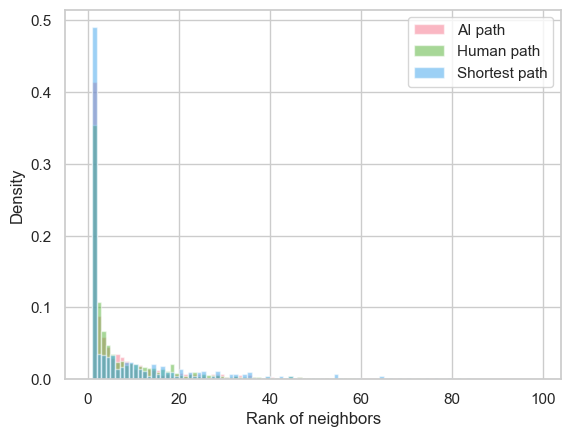

In [12]:
# plot the distribution of the rank of neighbors for AI paths and human paths
plt.hist(ai_scores, bins=range(100), alpha=0.5, label='AI path', color=palette[0], density=True)
plt.hist(human_scores, bins=range(100), alpha=0.5, label='Human path', color=palette[1], density=True)
plt.hist(optimal_scores, bins=range(100), alpha=0.5, label='Shortest path', color=palette[2], density=True)
plt.xlabel("Rank of neighbors")
plt.ylabel("Density")
plt.legend()
plt.show()


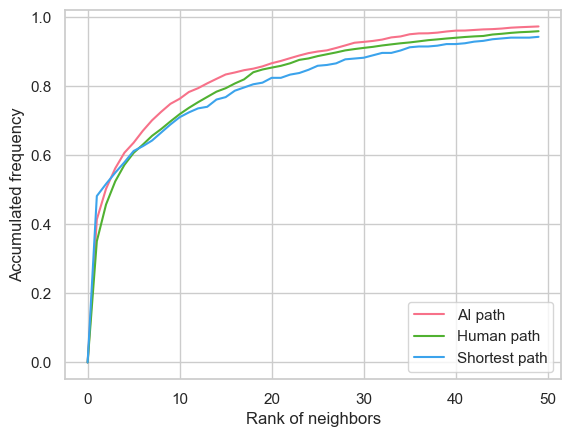

In [13]:
# plot the accumulated distribution of the rank of neighbors for AI paths and human paths simply in a line graph
ai_scores = np.sort(ai_scores)
human_scores = np.sort(human_scores)
optimal_scores_sorted = np.sort(optimal_scores)

# calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores_sorted)

# calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq)/len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq)/len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq)/len(optimal_scores_sorted)

# plot the accumulated distribution of the rank of neighbors for AI paths and human paths, only show the first 50 ranks
plt.plot(ai_scores_accumulated[:50], label='AI path', color=palette[0])
plt.plot(human_scores_accumulated[:50], label='Human path', color=palette[1])
plt.plot(optimal_scores_accumulated[:50], label='Shortest path', color=palette[2])
plt.xlabel("Rank of neighbors")
plt.ylabel("Accumulated frequency")
plt.legend()
plt.show()


In [14]:
import plotly.graph_objects as go
import numpy as np

# Define fixed colors with transparency
PRIMARY_BLUE = "rgba(58, 85, 209, 0.7)"  # AI paths - Light Blue with opacity
SOFT_ORANGE = "rgba(242, 153, 74, 0.7)"  # Human paths - Soft Orange with opacity
LIGHT_GREEN = "rgba(111, 207, 151, 0.8)" # Shortest paths - Light Green with slight opacity
BACKGROUND = "#F0F4FF"                   # Plot background
LIGHT_GRAY = "#E0E8F0"                   # Grid lines

# Sort the scores
ai_scores = np.sort(np.array(ai_scores, dtype=int))                 # Convert to integer
human_scores = np.sort(np.array(human_scores, dtype=int))           # Convert to integer
optimal_scores_sorted = np.sort(np.array(optimal_scores, dtype=int)) # Convert to integer

# Calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores_sorted)

# Calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq) / len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq) / len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq) / len(optimal_scores_sorted)

# Plot the accumulated distribution (only first 50 ranks)
fig = go.Figure()

# AI path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=ai_scores_accumulated[:50],
    mode='lines',
    name='AI path',
    line=dict(color=PRIMARY_BLUE, width=3)
))

# Human path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=human_scores_accumulated[:50],
    mode='lines',
    name='Human path',
    line=dict(color=SOFT_ORANGE, width=3)
))

# Shortest path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=optimal_scores_accumulated[:50],
    mode='lines',
    name='Shortest path',
    line=dict(color=LIGHT_GREEN, width=3)
))

# Update layout for aesthetics
fig.update_layout(
    title="Accumulated Distribution of Rank of Neighbors",
    xaxis_title="Rank of Neighbors",
    yaxis_title="Accumulated Frequency",
    plot_bgcolor=BACKGROUND,
    paper_bgcolor=BACKGROUND,
    legend=dict(
        x=0.7, y=0.1,
        bgcolor=BACKGROUND,
        bordercolor=LIGHT_GRAY,
        borderwidth=1
    ),
    font=dict(size=12),
    width=900,   # Fixed width
    height=600   # Fixed height
)

# Update grid line styles
fig.update_xaxes(showgrid=True, gridcolor=LIGHT_GRAY, dtick=5)
fig.update_yaxes(showgrid=True, gridcolor=LIGHT_GRAY)

# Show the interactive plot
fig.show()


In [15]:
# pio.write_html(fig, "img/accumulated_distribution_of_rank_of_neighbors.html", full_html=True)


In [16]:
# Calculate the rank of degrees condition on low similarity with destination
ai_degree_scores = {}
human_degree_scores = {}
optimal_degree_scores = {}

for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.3) for path in ai_path]
    human_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.3) for path in human_path]
    optimal_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.3) for path in shortest_paths[pair]]

ai_scores = [score for pair in ori_dest for score in ai_degree_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_degree_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_degree_scores[pair]]
ai_scores = np.array([score for sublist in ai_scores for score in sublist])
human_scores = np.array([score for sublist in human_scores for score in sublist])
optimal_scores = np.array([score for sublist in optimal_scores for score in sublist])


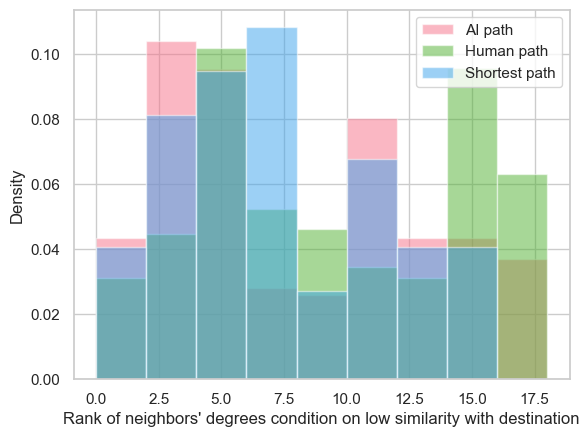

In [17]:
plt.hist(ai_scores, bins=range(0, 20, 2), alpha=0.5, label='AI path', color=palette[0], density=True)
plt.hist(human_scores, bins=range(0, 20, 2), alpha=0.5, label='Human path', color=palette[1], density=True)
plt.hist(optimal_scores, bins=range(0, 20, 2), alpha=0.5, label='Shortest path', color=palette[2], density=True)
plt.xlabel("Rank of neighbors' degrees condition on low similarity with destination")
plt.ylabel("Density")
plt.legend()
plt.show()

[  4   4   4  11  11  11   2   2   2   3   3   3   3  13  13  13  13  13
   1   1   1   1  21  21  21   4   4  22   4  31   4  31   4  31   4  31
   4  31   5   5   5   5   5   3   3   1   7   6   6   6   6   6  12   3
  10   3  10   3  10   3  10   3  10  29  53  36  31  22  20  14  29  68
  18  12   4  15  22   9  39  52  14  29  53  14  28  56   5  13  52  14
  29  53  14  13  16  52   9  15  67  31  22  27  61   4   9   4  13  31
  31   8   3   3  44  80  38  67  66  38  80  38  67  66  57   5   5   5
   5   5  50  50  50  50  50 210 148 101 198  39  27   8   9  32   3  25
   3  25   7   3   3   3  13  28  13  14  13   1  13  74   1  13  74   6
  74   1  13  74   1  13  43  11  11  11  11  11   3  17   3  17  76  52
  74  18  18  18  18  18  34  34  34  30  34   5   1   2   3   1  10   3
   1   2   3  13   2   5   1   2   4 118 118 118 118 118   2   2   2  10
  10   2   5  15  61  14  14  10  10   4   7   6  15  10  10   2   4   4
  10  18   3   5   2   5  13  17  18 142 120  77  1

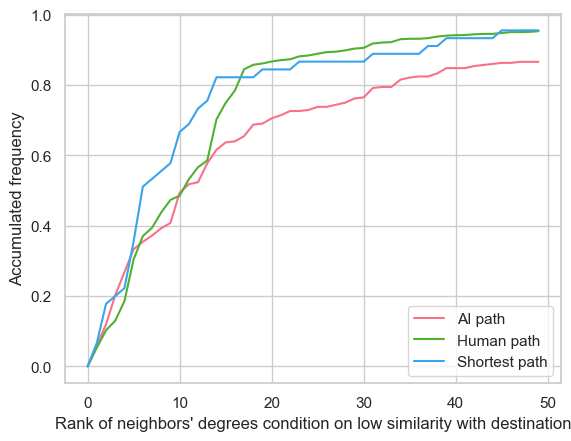

In [18]:
print(ai_scores)
# plot the accumulated distribution of the rank of neighbors for AI paths and human paths simply in a line graph
ai_scores = np.sort(ai_scores)
human_scores = np.sort(human_scores)
optimal_scores_sorted = np.sort(optimal_scores)

# calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores_sorted)

# calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq)/len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq)/len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq)/len(optimal_scores_sorted)

# plot the accumulated distribution of the rank of neighbors for AI paths and human paths, only show the first 50 ranks
plt.plot(ai_scores_accumulated[:50], label='AI path', color=palette[0])
plt.plot(human_scores_accumulated[:50], label='Human path', color=palette[1])
plt.plot(optimal_scores_accumulated[:50], label='Shortest path', color=palette[2])
plt.xlabel("Rank of neighbors' degrees condition on low similarity with destination")
plt.ylabel("Accumulated frequency")
plt.legend()
plt.show()

In [19]:
import plotly.graph_objects as go
import numpy as np

# Convert scores to integers
ai_scores = np.sort(np.array(ai_scores, dtype=int))                 # Convert AI scores to integers
human_scores = np.sort(np.array(human_scores, dtype=int))           # Convert Human scores to integers
optimal_scores_sorted = np.sort(np.array(optimal_scores, dtype=int))       # Convert Optimal scores to integers

# Calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores_sorted)

# Calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq) / len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq) / len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq) / len(optimal_scores_sorted)

# Plot the accumulated distribution (only first 50 ranks)
fig = go.Figure()

# AI path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=ai_scores_accumulated[:50],
    mode='lines',
    name='AI path',
    line=dict(color="rgba(58, 85, 209, 0.7)", width=3)  # PRIMARY_BLUE
))

# Human path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=human_scores_accumulated[:50],
    mode='lines',
    name='Human path',
    line=dict(color="rgba(242, 153, 74, 0.7)", width=3)  # SOFT_ORANGE
))

# Shortest path
fig.add_trace(go.Scatter(
    x=list(range(50)),
    y=optimal_scores_accumulated[:50],
    mode='lines',
    name='Shortest path',
    line=dict(color="rgba(111, 207, 151, 0.8)", width=3)  # LIGHT_GREEN
))

# Update layout for aesthetics
fig.update_layout(
    title="Accumulated Distribution of Rank of Neighbors' Degrees Conditioned on Low Similarity with Destination",
    xaxis_title="Rank of neighbors' degrees conditioned on low similarity with destination",
    yaxis_title="Accumulated frequency",
    plot_bgcolor="rgba(240, 244, 255, 1)",  # Background
    paper_bgcolor="rgba(240, 244, 255, 1)",  # Paper background
    font=dict(size=12),
    width=900,   # Fixed width
    height=600   # Fixed height
)

# Update grid line styles
fig.update_xaxes(showgrid=True, gridcolor="rgba(224, 232, 240, 1)", dtick=5)
fig.update_yaxes(showgrid=True, gridcolor="rgba(224, 232, 240, 1)")

# Show the interactive plot
fig.show()
# pio.write_html(fig, "img/accumulated_distribution_of_rank_of_neighbors_conditioned_on_low_similiarity.html", full_html=True)


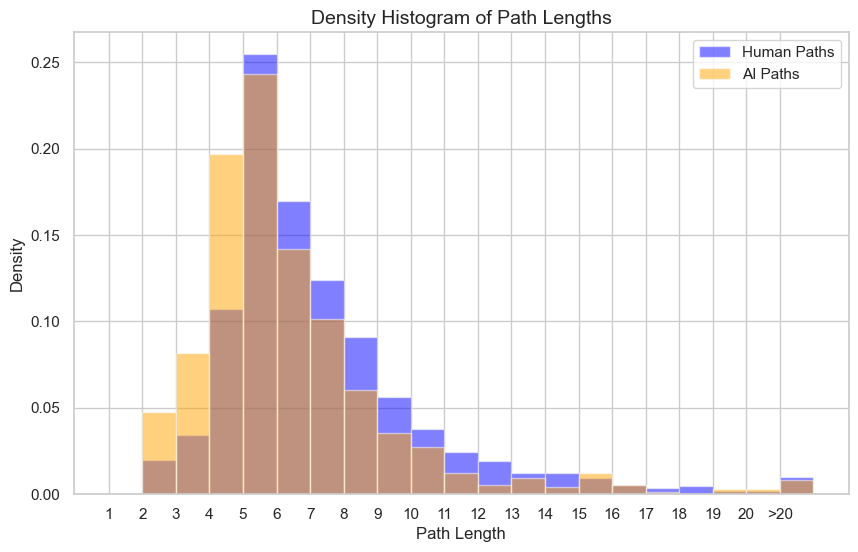

In [20]:
# Path Length distribution Plot
human_lengths_flat = [length for path in human_path_len for length in path]
ai_lengths_flat = [length for path in ai_path_len for length in path]


# Cap the path lengths at 20 and group all lengths >20 into a single bin
human_lengths_capped = [length if length <= 20 else 21 for length in human_lengths_flat]
ai_lengths_capped = [length if length <= 20 else 21 for length in ai_lengths_flat]

# Create the histogram with capped lengths
bins = list(range(1, 22)) + [22]  # Adding a bin for >20
plt.figure(figsize=(10, 6))
plt.hist(human_lengths_capped, bins=bins, alpha=0.5, label="Human Paths", color="blue", density=True)
plt.hist(ai_lengths_capped, bins=bins, alpha=0.5, label="AI Paths", color="orange", density=True)
plt.xticks(range(1, 22), labels=[str(i) for i in range(1, 21)] + ['>20'])
plt.title('Density Histogram of Path Lengths', fontsize=14)
plt.xlabel('Path Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [21]:
filtering_length = 5
first_n = 4

# filtered_ai_scores = score_filtering(ai_closeness_scores, ai_path_len, filtering_length, first_n)
# filtered_human_scores = score_filtering(human_closeness_scores, human_path_len, filtering_length, first_n)
filtered_ai_scores = score_filtering(ai_target_scores, ai_path_len, filtering_length, first_n)
filtered_human_scores = score_filtering(human_target_scores, human_path_len, filtering_length, first_n)
filtered_shortest_scores = score_filtering(optimal_target_scores, shortest_path_len, filtering_length, first_n)

ai_filtered_count = sum(len(list) for list in filtered_ai_scores.values())
human_filtered_count = sum(len(list) for list in filtered_human_scores.values())
shortest_filtered_count = sum(len(list) for list in filtered_shortest_scores.values())
ai_filtered_count, human_filtered_count, shortest_filtered_count

(493, 4934, 19)

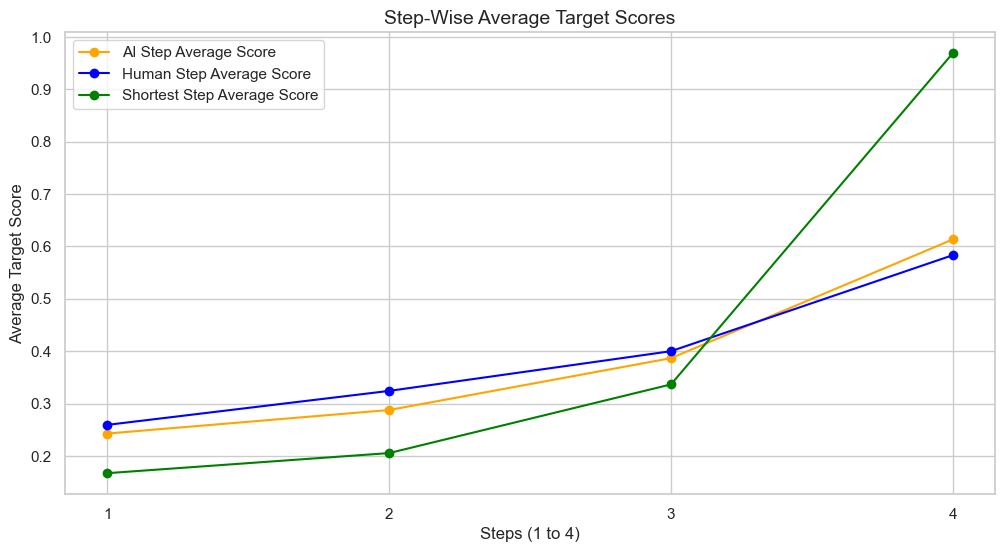

In [22]:
steps = list(range(1, first_n+1))

normalized_ai_scores = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_ai_scores.items()
]
normalized_human_scores = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_human_scores.items()
]
normalized_shortest_scores = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_shortest_scores.items()
]

# Convert filtered scores to NumPy arrays for easier manipulation
ai_scores_array = np.array(normalized_ai_scores)
human_scores_array = np.array(normalized_human_scores)
human_scores_array = human_scores_array[~np.isnan(human_scores_array).any(axis=1)]
shortest_scores_array = np.array(normalized_shortest_scores)

# Compute average scores for each step
ai_step_avg_scores = ai_scores_array.mean(axis=0)
human_step_avg_scores = human_scores_array.mean(axis=0)
shortest_step_avg_scores = shortest_scores_array.mean(axis=0)

# Plot step-wise average scores
plt.figure(figsize=(12, 6))
plt.plot(steps, ai_step_avg_scores, label='AI Step Average Score', marker='o', color='orange')
plt.plot(steps, human_step_avg_scores, label='Human Step Average Score', marker='o', color='blue')
plt.plot(steps, shortest_step_avg_scores, label='Shortest Step Average Score', marker='o', color='green')

plt.title('Step-Wise Average Target Scores', fontsize=14)
plt.xlabel(f'Steps (1 to {first_n})', fontsize=12)
plt.ylabel('Average Target Score', fontsize=12)
plt.xticks(steps)
plt.legend()
plt.show()

In [23]:
# Path Degree Analysis
in_degrees = dict(G.in_degree())  
out_degrees = dict(G.out_degree()) 
total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in set(in_degrees) | set(out_degrees)}

AI_path_degrees = compute_path_degrees(AI_paths, out_degrees)
human_path_degrees = compute_path_degrees(human_paths, out_degrees)
shortest_path_degrees = compute_path_degrees(shortest_paths, out_degrees)

degree_filtering_length = 3
degree_first_n = 3
filtered_ai_degrees = score_filtering(AI_path_degrees, ai_path_len, degree_filtering_length, degree_first_n)
filtered_human_degrees = score_filtering(human_path_degrees, human_path_len, degree_filtering_length, degree_first_n)
filtered_shortest_degrees = score_filtering(shortest_path_degrees, shortest_path_len, degree_filtering_length, degree_first_n)


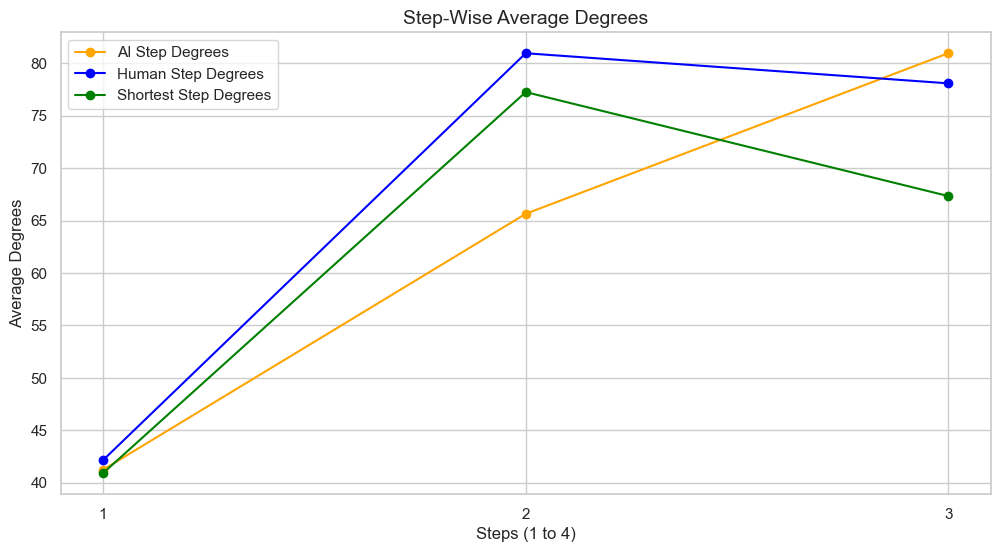

In [24]:
steps = list(range(1, degree_first_n+1))

# Filter out degrees that do not match the expected length of 9
filtered_ai_degrees = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_ai_degrees.items()
]
filtered_human_degrees = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_human_degrees.items()
]
filtered_shortest_degrees = [
    list(np.mean(score_lists, axis=0)) for key, score_lists in filtered_shortest_degrees.items()
]

# Convert filtered degrees to NumPy arrays for easier manipulation
ai_degrees_array = np.array(filtered_ai_degrees)
human_degrees_array = np.array(filtered_human_degrees)
human_degrees_array = human_degrees_array[~np.isnan(human_degrees_array).any(axis=1)]
shortest_degrees_array = np.array(filtered_shortest_degrees)

# Compute average degrees for each step
ai_step_avg_degrees = ai_degrees_array.mean(axis=0)
human_step_avg_degrees = human_degrees_array.mean(axis=0)
shortest_step_avg_degrees = shortest_degrees_array.mean(axis=0)

# Plot step-wise average degrees
plt.figure(figsize=(12, 6))
plt.plot(steps, ai_step_avg_degrees, label='AI Step Degrees', marker='o', color='orange')
plt.plot(steps, human_step_avg_degrees, label='Human Step Degrees', marker='o', color='blue')
plt.plot(steps, shortest_step_avg_degrees, label='Shortest Step Degrees', marker='o', color='green')

plt.title('Step-Wise Average Degrees', fontsize=14)
plt.xlabel(f'Steps (1 to {first_n})', fontsize=12)
plt.ylabel('Average Degrees', fontsize=12)
plt.xticks(steps)
plt.legend()
plt.show()

In [25]:
ai_good_degrees = []
ai_bad_degrees = []
human_good_degrees = []
human_bad_degrees = []
optimal_degrees = []

ai_good_scores = []
ai_bad_scores = []
human_good_scores = []
human_bad_scores = []
optimal_scores = []

avg_human_path_len = [np.sum(path_lens)/len(path_lens) for path_lens in human_path_len]
avg_ai_path_len = [np.sum(path_lens)/len(path_lens) for path_lens in ai_path_len]

for i, pair in zip(range(len(AI_paths)), AI_paths.keys()):
    for j in range(len(AI_paths[pair])):
        if ai_path_len[i][j] <= avg_ai_path_len[i]:
            ai_good_degrees.append(AI_path_degrees[pair][j][1])
            ai_good_scores.append(ai_closeness_scores[pair][j][0])
        if ai_path_len[i][j] > avg_ai_path_len[i]:
            ai_bad_degrees.append(AI_path_degrees[pair][j][1])
            ai_bad_scores.append(ai_closeness_scores[pair][j][0])
    for k in range(len(human_paths[pair])):
        if human_path_len[i][k] <= avg_human_path_len[i]:
            human_good_degrees.append(human_path_degrees[pair][k][1])
            human_good_scores.append(human_closeness_scores[pair][k][0])
        if human_path_len[i][k] > avg_ai_path_len[i]:
            human_bad_degrees.append(human_path_degrees[pair][k][1])
            human_bad_scores.append(human_closeness_scores[pair][k][0])
    optimal_degrees.append(shortest_path_degrees[pair][0][1])
    optimal_scores.append(optimal_closeness_scores[pair][0][0])

human_bad_scores = list(np.array(human_bad_scores)[~np.isnan(human_bad_scores)])

C:\Users\97065\AppData\Local\Temp\ipykernel_5468\2805038639.py:14: RuntimeWarning:

invalid value encountered in scalar divide



In [26]:
import plotly.graph_objects as go
import numpy as np

# Define fixed colors with transparency
PRIMARY_BLUE = "rgba(58, 85, 209, 0.7)"  # AI paths - Light Blue with opacity
SOFT_ORANGE = "rgba(242, 153, 74, 0.7)"  # Human paths - Soft Orange with opacity
LIGHT_GREEN = "rgba(111, 207, 151, 0.8)" # Shortest paths - Light Green with slight opacity

# Data for degrees and scores
degree_means = [np.mean(ai_good_degrees), np.mean(ai_bad_degrees), 
                np.mean(human_good_degrees), np.mean(human_bad_degrees), 
                np.mean(optimal_degrees)]
score_means = [np.mean(ai_good_scores), np.mean(ai_bad_scores), 
               np.mean(human_good_scores), np.mean(human_bad_scores), 
               np.mean(optimal_scores)]

# Labels for the groups
degree_labels = ["Good AI", "Bad AI", "Good Human", "Bad Human", "Optimal"]
score_labels = ["Good AI", "Bad AI", "Good Human", "Bad Human", "Optimal"]

# Define colors
bar_colors = [PRIMARY_BLUE, PRIMARY_BLUE, SOFT_ORANGE, SOFT_ORANGE, LIGHT_GREEN]

# Plotting Degrees
fig_degrees = go.Figure()

fig_degrees.add_trace(go.Bar(
    x=degree_labels,
    y=degree_means,
    marker_color=bar_colors,
    hovertemplate=["%{x}: %{y:.2f}<extra></extra>" for x, y in zip(degree_labels, degree_means)]  # Hover template
))

fig_degrees.update_layout(
    title="Mean Out-Degrees Comparison",
    # xaxis_title="Groups",
    yaxis_title="First Step Out-Degrees",
    plot_bgcolor="rgba(240, 244, 255, 1)",  # Background
    paper_bgcolor="rgba(240, 244, 255, 1)",  # Paper background
    font=dict(size=12),
    width=700,
    height=500
)

# Plotting Scores
fig_scores = go.Figure()

fig_scores.add_trace(go.Bar(
    x=score_labels,
    y=score_means,
    marker_color=bar_colors,
    hovertemplate=["%{x}: %{y:.2f}<extra></extra>" for x, y in zip(score_labels, score_means)]  # Hover template
))

fig_scores.update_layout(
    title="Mean Closeness Scores Comparison",
    # xaxis_title="Groups",
    yaxis_title="First Step Closeness Scores",
    plot_bgcolor="rgba(240, 244, 255, 1)",  # Background
    paper_bgcolor="rgba(240, 244, 255, 1)",  # Paper background
    font=dict(size=12),
    width=700,
    height=500
)

# Show both figures
fig_degrees.show()
# pio.write_html(fig_degrees, "pages/mean_out_degrees_comparison.html", full_html=True)

fig_scores.show()
# pio.write_html(fig_scores, "pages/mean_closeness_scores_comparison.html", full_html=True)


In [27]:
before_tuning_paths = load_ai_paths('paths_before_tuning', ori_dest)
after_4o_tuning_paths = load_ai_paths('paths_after_tuning', ori_dest)
after_4o_mini_tuning_paths = load_ai_paths('paths_after_tuning_4o_mini', ori_dest)

plot_updated_task_path_length_comparison(before_tuning_paths, after_4o_tuning_paths, after_4o_mini_tuning_paths, ori_dest, shortest_paths, sample_fraction=0.3, fixed_height_per_pair=50, fixed_width=1400, x_jitter_offset=0.025, seed=58, y_offset=0.15)

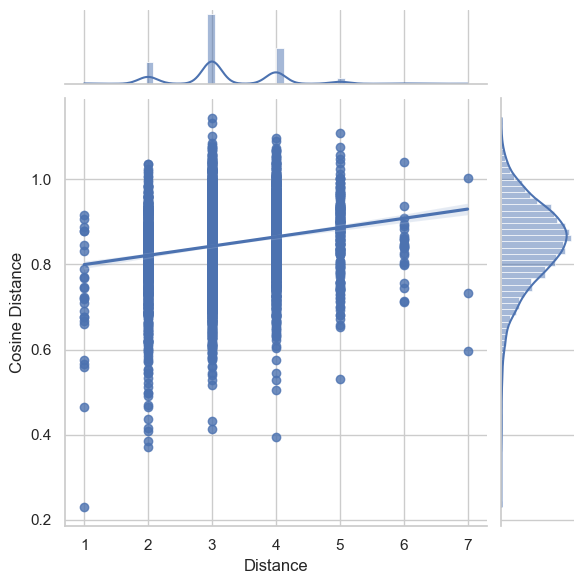

In [28]:
correlation_between_embedding_and_distance(G, sentence_embeddings, 5000)

In [29]:
path_1 = load_ai_paths('paths', ori_dest)
path_2 = load_ai_paths('paths_improved_prompt', ori_dest)
print("Path 1: baseline, Path 2: manually improved prompt")
paths_comparation(path_1, path_2, ori_dest)

path_1 = load_ai_paths('paths', ori_dest)
path_2 = load_ai_paths('paths_before_tuning', ori_dest)
print("Path 1: baseline, Path 2: task modification")
paths_comparation(path_1, path_2, ori_dest)


Path 1: baseline, Path 2: manually improved prompt
Failure rate for Paths 1: 0.0, Path 2: 0.0
Number of paths that are shorter for Paths 1: 34, Path 2: 70
Average for Path 1: 6.20356394129979, Path 2: 5.7991614255765205
Median path length for Path 1: 5.2, Path 2: 5.2
Path 1: baseline, Path 2: task modification
Failure rate for Paths 1: 0.0, Path 2: 0.06918238993710692
Number of paths that are shorter for Paths 1: 41, Path 2: 67
Average for Path 1: 6.102815315315316, Path 2: 5.6824324324324325
Median path length for Path 1: 5.2, Path 2: 5.0
